<a href="https://colab.research.google.com/github/Natalkina/DataScience/blob/main/HW8__tensorflow_mnist_hw_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [ ]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")  # Ваги шару
        self.b = tf.Variable(tf.zeros([out_features]), name="b")  # Зсув шару

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return y

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.dense1 = tf.keras.layers.Dense(units=n_hidden_1, activation='relu')
    self.dense2 = tf.keras.layers.Dense(units=n_hidden_2, activation='relu')
    self.dense_output = tf.keras.layers.Dense(units=10, activation=None)


  def __call__(self, x):
    x = self.dense1(x)
    x = self.dense2(x)

    x = self.dense_output(x)

    return tf.nn.softmax(x)

In [ ]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(predicted_classes, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [ ]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_variables = neural_net.trainable_variables
    gradients = g.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        batch_y = tf.cast(batch_y, tf.int64)
        acc = accuracy(pred, batch_y)
        loss = cross_entropy(pred, batch_y)
        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())

Step 100, Loss: 96.36661529541016, Accuracy: 0.91796875
Step 200, Loss: 44.83836364746094, Accuracy: 0.94921875
Step 300, Loss: 57.428375244140625, Accuracy: 0.94140625
Step 400, Loss: 40.634483337402344, Accuracy: 0.94921875
Step 500, Loss: 30.087717056274414, Accuracy: 0.97265625
Step 600, Loss: 17.80853843688965, Accuracy: 0.984375
Step 700, Loss: 20.133888244628906, Accuracy: 0.9765625
Step 800, Loss: 16.856801986694336, Accuracy: 0.98828125
Step 900, Loss: 18.743656158447266, Accuracy: 0.98046875
Step 1000, Loss: 15.383560180664062, Accuracy: 0.98828125
Step 1100, Loss: 20.81490707397461, Accuracy: 0.97265625
Step 1200, Loss: 13.163715362548828, Accuracy: 0.9921875
Step 1300, Loss: 13.177566528320312, Accuracy: 0.9921875
Step 1400, Loss: 7.176866054534912, Accuracy: 0.99609375
Step 1500, Loss: 6.654071807861328, Accuracy: 0.99609375
Step 1600, Loss: 13.512414932250977, Accuracy: 0.98046875
Step 1700, Loss: 5.985861778259277, Accuracy: 0.99609375
Step 1800, Loss: 3.9987330436706543

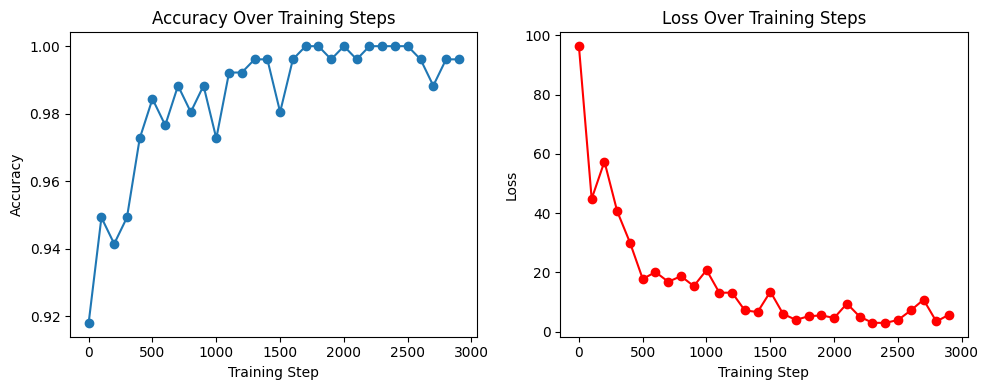

In [ ]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, training_steps + 1, display_step), accuracy_history, marker='o')
plt.title('Accuracy Over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, training_steps + 1, display_step), loss_history, marker='o', color='r')
plt.title('Loss Over Training Steps')
plt.xlabel('Training Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Вычислите точность обученной нейросети
pred = neural_net(x_test)
print(f'Test Accuracy: {accuracy(pred, y_test)}')

Test Accuracy: 0.9790999889373779


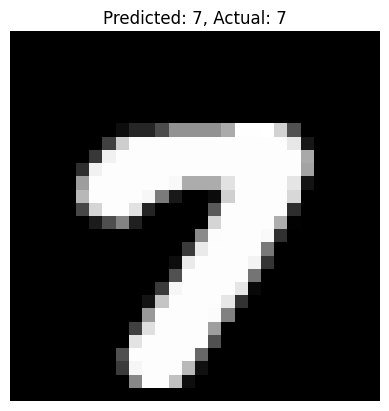

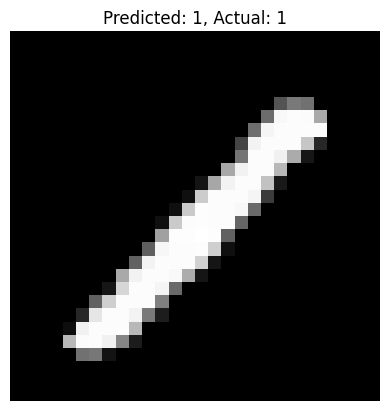

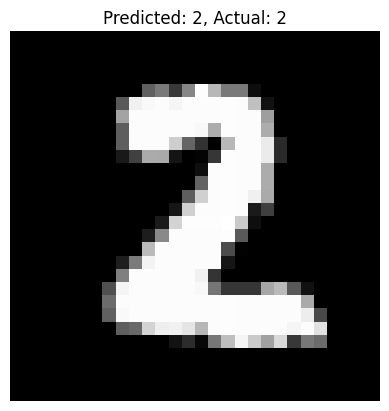

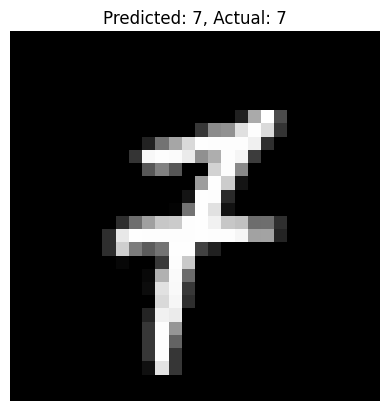

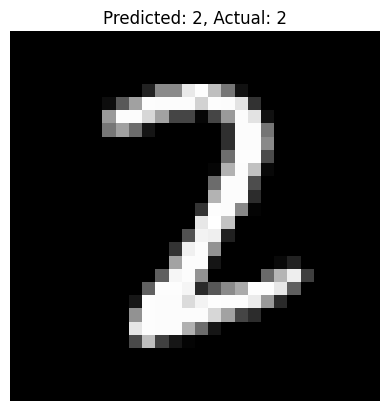

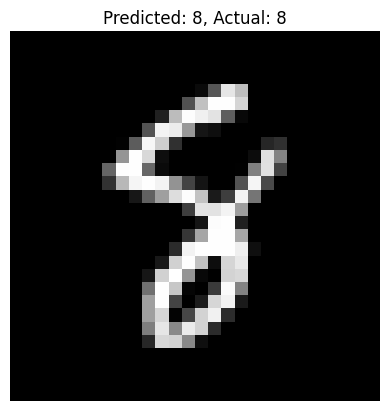

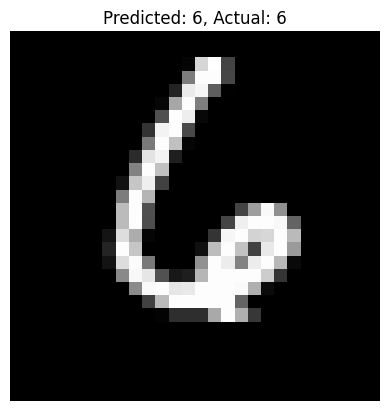

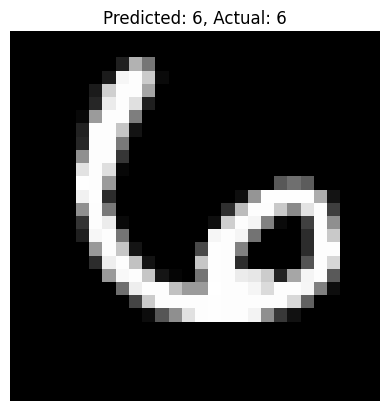

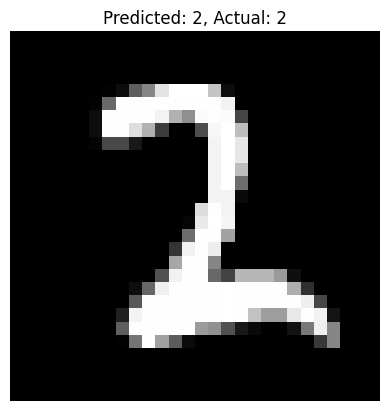

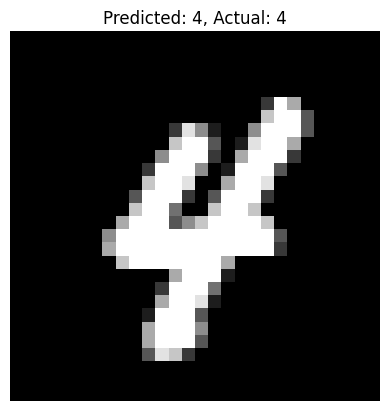

Error Rate: 0.0


In [ ]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

error_count = 0
random_samples = np.random.choice(len(x_test), size=10, replace=False)

for idx in random_samples:
    test_image = x_test[idx]
    test_label = y_test[idx]

    prediction = np.argmax(neural_net(test_image[None, ...]))

    plt.figure()
    plt.imshow(test_image.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {prediction}, Actual: {test_label}")
    plt.axis('off')
    plt.show()

    if prediction != test_label:
        error_count += 1

error_rate = error_count / len(random_samples)
print(f"Error Rate: {error_rate}")